# Prerequisites

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.ensemble import HistGradientBoostingClassifier

### Setting a seed

In [2]:
SEED = 0

In [3]:
np.random.seed(SEED)

### Loading data

In [4]:
df_train = pd.read_csv(os.path.join('data', 'training.csv'), delimiter=';')
df_test = pd.read_csv(os.path.join('data', 'validation.csv'), delimiter=';')

### Assumptions
* data from the training.csv file will be treated as the dataset provided for creating the model and later split into training and validation datasets
* data from the validation.csv file will be treated as example data from production provided by the client and used as a testing dataset

# Data Exploration

In [5]:
df_train.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,a,"17,92","5,4e-05",u,"-0,840182024985552","0,522882590622095","1,75",f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,"16,92","3,35e-05",y,"-2,15963506605476","0,774187133555115","0,29",f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,"31,25","0,0001125",u,"1,75068668089807","0,76036270650308",0,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,"48,17","0,0001335",u,"4,17487068567425","0,888963139486792","0,335",f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,"32,33","0,00035",u,"-3,78547915257514","0,489023844085239","0,5",f,f,0,t,g,232.0,0,2320000.0,f,0,no.


In [6]:
df_test.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,b,"32,33","0,00075",u,"0,840107307","0,544982291","1,585",t,f,0,t,s,420.0,0,4200000,NaN,1,no.
1,b,"23,58","0,000179",u,"-4,174395711","0,864361709","0,54",f,f,0,t,g,136.0,1,1360000,NaN,0,no.
2,b,"36,42","7,50E-05",y,"2,23222567","0,627475551","0,585",f,f,0,f,g,240.0,3,2400000,NaN,1,no.
3,b,"18,42","0,0010415",y,"-2,469969629","0,846741022","0,125",t,f,0,f,g,120.0,375,1200000,NaN,0,no.
4,b,"24,5","0,0013335",y,"-3,149422333","0,321087006","0,04",f,f,0,t,g,120.0,475,1200000,f,1,no.


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v1          3661 non-null   object 
 1   v2          3661 non-null   object 
 2   v3          3700 non-null   object 
 3   v4          3636 non-null   object 
 4   v5          3700 non-null   object 
 5   v6          3700 non-null   object 
 6   v7          3700 non-null   object 
 7   v8          3700 non-null   object 
 8   v9          3700 non-null   object 
 9   v10         3700 non-null   int64  
 10  v11         3700 non-null   object 
 11  v12         3700 non-null   object 
 12  v13         3600 non-null   float64
 13  v14         3700 non-null   int64  
 14  v15         3600 non-null   float64
 15  v16         1555 non-null   object 
 16  v17         3700 non-null   int64  
 17  classLabel  3700 non-null   object 
dtypes: float64(2), int64(3), object(13)
memory usage: 520.4+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v1          197 non-null    object 
 1   v2          197 non-null    object 
 2   v3          200 non-null    object 
 3   v4          198 non-null    object 
 4   v5          200 non-null    object 
 5   v6          200 non-null    object 
 6   v7          200 non-null    object 
 7   v8          200 non-null    object 
 8   v9          200 non-null    object 
 9   v10         200 non-null    int64  
 10  v11         200 non-null    object 
 11  v12         200 non-null    object 
 12  v13         197 non-null    float64
 13  v14         200 non-null    int64  
 14  v15         197 non-null    object 
 15  v16         89 non-null     object 
 16  v17         200 non-null    int64  
 17  classLabel  200 non-null    object 
dtypes: float64(1), int64(3), object(14)
memory usage: 28.2+ KB


In [9]:
df_train.describe()

,v10,v13,v14,v15,v17
count,3700.000000,3600.000000,3700.000000,3.600000e+03,3700.000000
mean,4.160000,162.695000,2246.705946,1.626950e+06,0.925405
std,6.750553,156.045682,8708.571126,1.560457e+06,0.262772
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000e+00,1.000000
50%,2.000000,120.000000,113.000000,1.200000e+06,1.000000
75%,6.000000,280.000000,1059.750000,2.800000e+06,1.000000
max,67.000000,1160.000000,100000.000000,1.160000e+07,1.000000


In [10]:
df_test.describe()

,v10,v13,v14,v17
count,200.000000,197.000000,200.000000,200.000000
mean,2.795000,199.903553,659.720000,0.500000
std,4.233508,209.373399,1603.900294,0.501255
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.000000,0.000000,0.000000
50%,0.000000,160.000000,4.500000,0.500000
75%,5.000000,280.000000,500.000000,1.000000
max,20.000000,2000.000000,10000.000000,1.000000


In [11]:
df_train['classLabel'].value_counts()

classLabel
yes.    3424
no.      276
Name: count, dtype: int64

In [12]:
df_test['classLabel'].value_counts()

classLabel
no.     107
yes.     93
Name: count, dtype: int64

### Conclusions
* the training dataset is highly unbalanced (too high for oversampling)
* both datasets contain values that need to be fixed (eg. commas instead of dots) and turned into floats
* some features need to be encoded using binary encoding
* some features need to be encoded using one-hot encoding
* missing values should not be dropped because the testing dataset also contains them hence they should be handled
* there are some outliers but both datasets contain them so I decided to not remove them

# Preprocessing and Data Analysis

### Method for fixing and encoding the data

In [13]:
def preprocess_data(df):
    label_encoder = LabelEncoder()

    df['v1'] = label_encoder.fit_transform(df['v1'])
    df['v8'] = label_encoder.fit_transform(df['v8'])
    df['v9'] = label_encoder.fit_transform(df['v9'])
    df['v11'] = label_encoder.fit_transform(df['v11'])
    df['v16'] = label_encoder.fit_transform(df['v16'])
    df['v17'] = label_encoder.fit_transform(df['v17'])
    df['classLabel'] = label_encoder.fit_transform(df['classLabel'])

    df['v14'] = df['v14'].astype(float)

    df['v2'] = df['v2'].str.replace(',', '.').astype(float)
    df['v3'] = df['v3'].str.replace(',', '.').astype(float)
    df['v5'] = df['v5'].str.replace(',', '.').astype(float)
    df['v6'] = df['v6'].str.replace(',', '.').astype(float)
    df['v7'] = df['v7'].str.replace(',', '.').astype(float)
    df['v15'] = df['v15'].apply(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)

    df = pd.concat([df, pd.get_dummies(df['v4'], prefix='v4')], axis=1)
    df = df.drop(['v4'], axis=1)

    df = pd.concat([df, pd.get_dummies(df['v12'], prefix='v12')], axis=1)
    df = df.drop(['v12'], axis=1)
    
    return df

In [14]:
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

In [15]:
df_train.columns.values

array(['v1', 'v2', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v13', 'v14', 'v15', 'v16', 'v17', 'classLabel', 'v4_l', 'v4_u',
       'v4_y', 'v12_g', 'v12_p', 'v12_s'], dtype=object)

In [16]:
df_test.columns.values

array(['v1', 'v2', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v13', 'v14', 'v15', 'v16', 'v17', 'classLabel', 'v4_u', 'v4_y',
       'v12_g', 'v12_o', 'v12_p', 'v12_s'], dtype=object)

### As we can see above, there are some uncommon columns after one-hot encoding. Fix below.

In [17]:
common_features = df_train.columns.intersection(df_test.columns)
df_train = df_train[common_features]
df_test = df_test[common_features]

### Plotting the correlation matrix

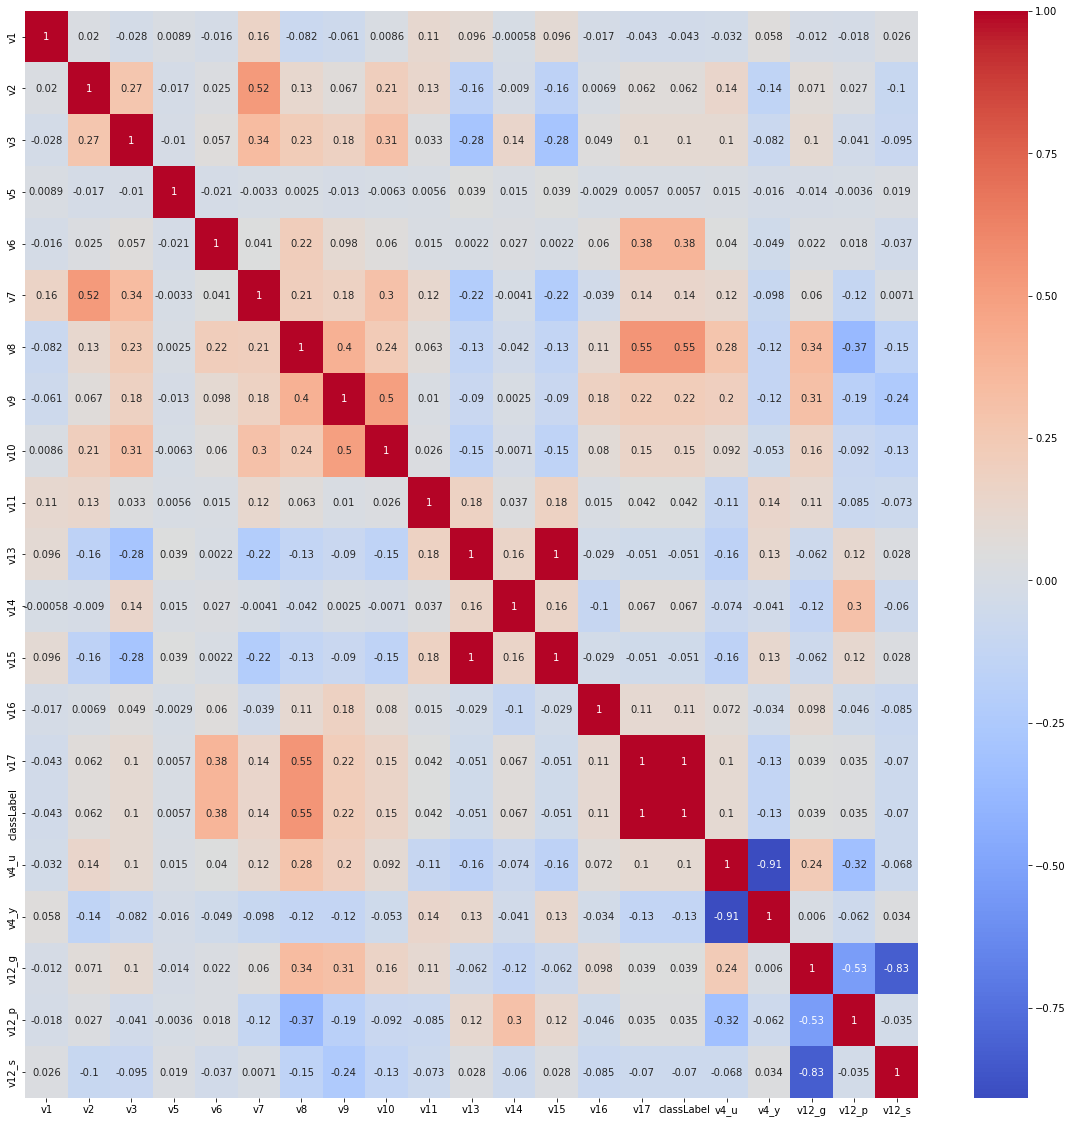

In [18]:
correlation_matrix_train = df_train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm')
plt.show()

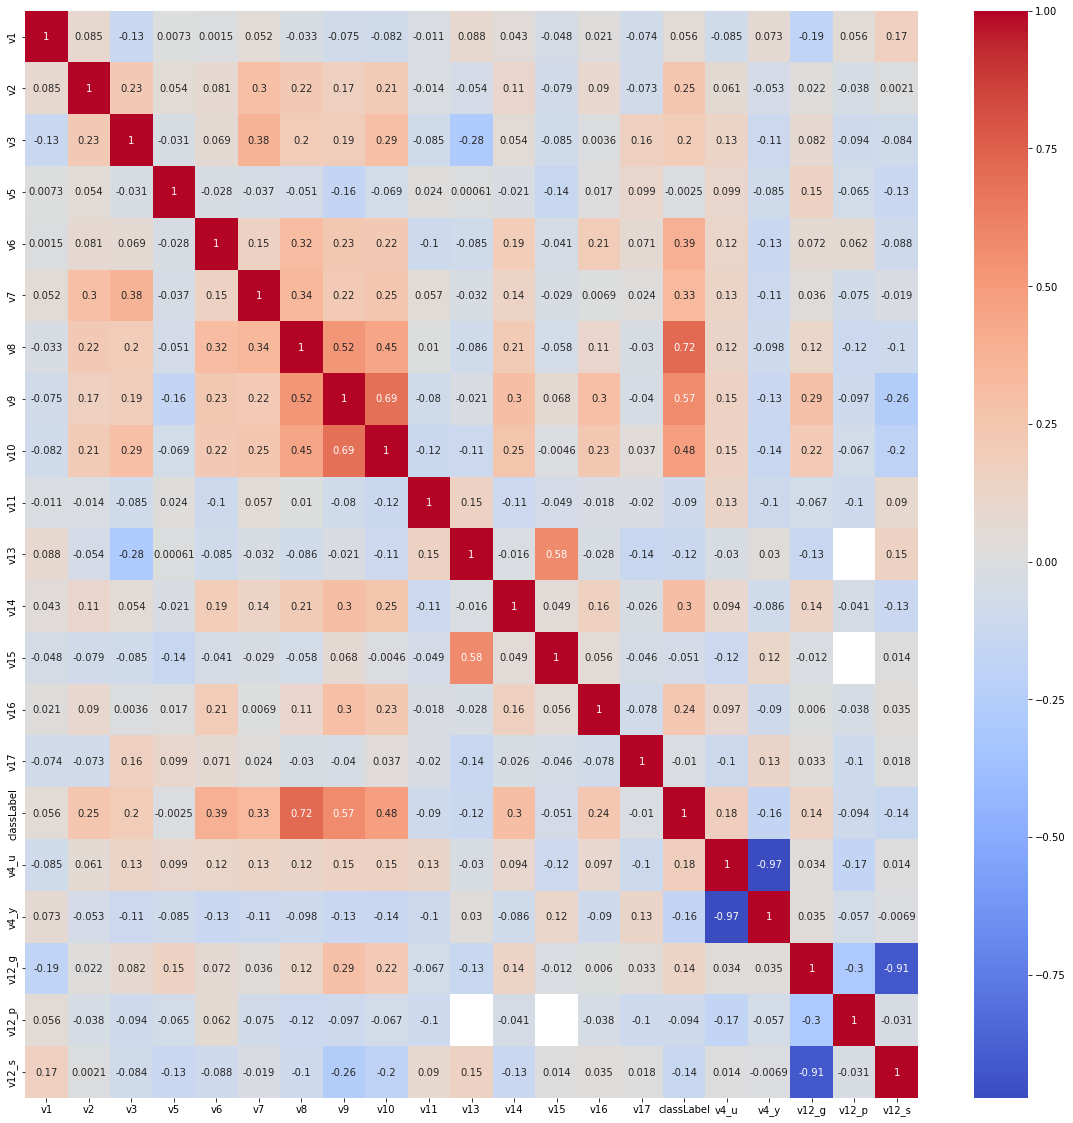

In [19]:
correlation_matrix_test = df_test.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_test, annot=True, cmap='coolwarm')
plt.show()

### Conclusions
* the testing dataset is much more various
* feature v5 does not correlate with any other feature and should be removed
* features v13 and v15 are duplicates hence one of them should be removed
* feature v17 looks like a class label on the training dataset but not on the testing dataset and should be removed due to this inconsistency

### Dropping columns

In [20]:
def drop_selected_columns(df, columns_to_drop):
    for column in list(columns_to_drop):
        df = df.drop(column, axis=1)

    return df

In [21]:
df_train = drop_selected_columns(df_train, ['v5', 'v15', 'v17'])
df_test = drop_selected_columns(df_test, ['v5', 'v15', 'v17'])

# Model Architecture Selection

### The model architecture will be selected during preliminary training. The basic requirement is to handle missing values. That is why three architectures were selected: XGBoost, LightGBM, and Gradient Boosting.

In [22]:
models = {
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Gradient Boosting': HistGradientBoostingClassifier(),
}

x_train, y_train = df_train.drop('classLabel', axis=1), df_train['classLabel']
x_test, y_test = df_test.drop('classLabel', axis=1), df_test['classLabel']

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name}: {accuracy:.2f}')

XGBoost: 0.86
LightGBM: 0.84
Gradient Boosting: 0.85


### XGBoost looks promising based on the preliminary training. It is a good choice also because of unbalanced data in the training dataset which XGBoost can handle.

### Plotting a feature importance plot

In [23]:
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

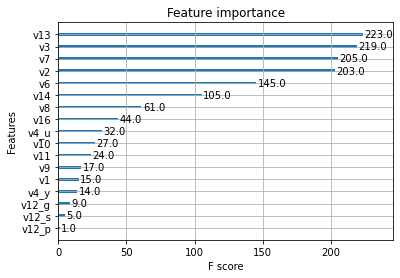

In [24]:
xgb.plot_importance(model)

### As we can see above v1 and v12 features look unimportant during the training. I decided to not remove v4_y because v4_u has much higher score.

In [25]:
df_train = drop_selected_columns(df_train, ['v1', 'v12_g', 'v12_p', 'v12_s'])
df_test = drop_selected_columns(df_test, ['v1', 'v12_g', 'v12_p', 'v12_s'])

### Preparing data for the training. Splitting training dataset into training and validation.

In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(
        df_train.drop('classLabel', axis=1), df_train['classLabel'], test_size=0.1, random_state=SEED)

x_test, y_test = df_test.drop('classLabel', axis=1), df_test['classLabel']

### Rescaling data

In [27]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

### I used Grid Search to fine-tune hyperparameters however, I decided to adjust those even more manually after observing not optimal learning curve (probably due to substantial differences between datasets).

In [28]:
def fine_tune_xgb_classifier(x, y):
    model = xgb.XGBClassifier()

    param_grid = {
        'learning_rate': [0.1, 0.3, 0.5],
        'n_estimators': [1000, 2000, 4000],
        'max_depth': [5, 6, 7],
        'min_child_weight': [3, 4, 5],
        'scale_pos_weight': [0.08],
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x, y)
    best_model = grid_search.best_estimator_
    tuning_results = grid_search.cv_results_

    return best_model

In [29]:
best_model = fine_tune_xgb_classifier(x_train, y_train)

print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=4000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


# Training the Model

In [30]:
params = {
    'objective': 'binary:logistic',
    'n_estimators': 2000,
    'max_depth': 6,
    'learning_rate': 0.5,
    'min_child_weight': 4,
    'scale_pos_weight': 0.08,
    'seed': SEED,    
}

In [31]:
model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train, eval_metric=['logloss'], eval_set=[(x_train, y_train), (x_valid, y_valid)])

[0]	validation_0-logloss:0.43389	validation_1-logloss:0.43404
[1]	validation_0-logloss:0.32770	validation_1-logloss:0.33260
[2]	validation_0-logloss:0.27104	validation_1-logloss:0.28009
[3]	validation_0-logloss:0.23638	validation_1-logloss:0.24186
[4]	validation_0-logloss:0.21276	validation_1-logloss:0.21652
[5]	validation_0-logloss:0.19628	validation_1-logloss:0.20253
[6]	validation_0-logloss:0.18175	validation_1-logloss:0.19038
[7]	validation_0-logloss:0.17334	validation_1-logloss:0.18144
[8]	validation_0-logloss:0.16655	validation_1-logloss:0.17601
[9]	validation_0-logloss:0.16190	validation_1-logloss:0.17254
[10]	validation_0-logloss:0.15448	validation_1-logloss:0.16517
[11]	validation_0-logloss:0.14867	validation_1-logloss:0.15598
[12]	validation_0-logloss:0.14206	validation_1-logloss:0.14926
[13]	validation_0-logloss:0.13780	validation_1-logloss:0.14369
[14]	validation_0-logloss:0.13400	validation_1-logloss:0.14134
[15]	validation_0-logloss:0.13105	validation_1-logloss:0.14005
[1

/home/adam/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-logloss:0.08542	validation_1-logloss:0.09507
[43]	validation_0-logloss:0.08459	validation_1-logloss:0.09341
[44]	validation_0-logloss:0.08329	validation_1-logloss:0.09210
[45]	validation_0-logloss:0.08279	validation_1-logloss:0.09150
[46]	validation_0-logloss:0.08220	validation_1-logloss:0.09102
[47]	validation_0-logloss:0.08182	validation_1-logloss:0.09006
[48]	validation_0-logloss:0.08127	validation_1-logloss:0.08956
[49]	validation_0-logloss:0.08094	validation_1-logloss:0.08963
[50]	validation_0-logloss:0.08022	validation_1-logloss:0.08938
[51]	validation_0-logloss:0.07967	validation_1-logloss:0.08872
[52]	validation_0-logloss:0.07914	validation_1-logloss:0.08733
[53]	validation_0-logloss:0.07863	validation_1-logloss:0.08568
[54]	validation_0-logloss:0.07775	validation_1-logloss:0.08464
[55]	validation_0-logloss:0.07727	validation_1-logloss:0.08412
[56]	validation_0-logloss:0.07631	validation_1-logloss:0.08339
[57]	validation_0-logloss:0.07566	validation_1-logloss:

[298]	validation_0-logloss:0.04225	validation_1-logloss:0.05757
[299]	validation_0-logloss:0.04223	validation_1-logloss:0.05752
[300]	validation_0-logloss:0.04222	validation_1-logloss:0.05768
[301]	validation_0-logloss:0.04219	validation_1-logloss:0.05750
[302]	validation_0-logloss:0.04216	validation_1-logloss:0.05757
[303]	validation_0-logloss:0.04208	validation_1-logloss:0.05741
[304]	validation_0-logloss:0.04210	validation_1-logloss:0.05731
[305]	validation_0-logloss:0.04205	validation_1-logloss:0.05723
[306]	validation_0-logloss:0.04201	validation_1-logloss:0.05727
[307]	validation_0-logloss:0.04189	validation_1-logloss:0.05791
[308]	validation_0-logloss:0.04186	validation_1-logloss:0.05742
[309]	validation_0-logloss:0.04178	validation_1-logloss:0.05734
[310]	validation_0-logloss:0.04177	validation_1-logloss:0.05727
[311]	validation_0-logloss:0.04167	validation_1-logloss:0.05716
[312]	validation_0-logloss:0.04170	validation_1-logloss:0.05705
[313]	validation_0-logloss:0.04166	valid

[554]	validation_0-logloss:0.03773	validation_1-logloss:0.05293
[555]	validation_0-logloss:0.03771	validation_1-logloss:0.05297
[556]	validation_0-logloss:0.03768	validation_1-logloss:0.05293
[557]	validation_0-logloss:0.03770	validation_1-logloss:0.05281
[558]	validation_0-logloss:0.03768	validation_1-logloss:0.05295
[559]	validation_0-logloss:0.03769	validation_1-logloss:0.05281
[560]	validation_0-logloss:0.03767	validation_1-logloss:0.05294
[561]	validation_0-logloss:0.03767	validation_1-logloss:0.05287
[562]	validation_0-logloss:0.03766	validation_1-logloss:0.05300
[563]	validation_0-logloss:0.03766	validation_1-logloss:0.05285
[564]	validation_0-logloss:0.03766	validation_1-logloss:0.05290
[565]	validation_0-logloss:0.03765	validation_1-logloss:0.05276
[566]	validation_0-logloss:0.03762	validation_1-logloss:0.05288
[567]	validation_0-logloss:0.03762	validation_1-logloss:0.05274
[568]	validation_0-logloss:0.03760	validation_1-logloss:0.05287
[569]	validation_0-logloss:0.03759	valid

[810]	validation_0-logloss:0.03570	validation_1-logloss:0.05147
[811]	validation_0-logloss:0.03571	validation_1-logloss:0.05150
[812]	validation_0-logloss:0.03572	validation_1-logloss:0.05138
[813]	validation_0-logloss:0.03569	validation_1-logloss:0.05144
[814]	validation_0-logloss:0.03571	validation_1-logloss:0.05139
[815]	validation_0-logloss:0.03567	validation_1-logloss:0.05139
[816]	validation_0-logloss:0.03566	validation_1-logloss:0.05136
[817]	validation_0-logloss:0.03567	validation_1-logloss:0.05139
[818]	validation_0-logloss:0.03565	validation_1-logloss:0.05138
[819]	validation_0-logloss:0.03566	validation_1-logloss:0.05142
[820]	validation_0-logloss:0.03564	validation_1-logloss:0.05140
[821]	validation_0-logloss:0.03565	validation_1-logloss:0.05144
[822]	validation_0-logloss:0.03563	validation_1-logloss:0.05143
[823]	validation_0-logloss:0.03561	validation_1-logloss:0.05139
[824]	validation_0-logloss:0.03560	validation_1-logloss:0.05151
[825]	validation_0-logloss:0.03561	valid

[1065]	validation_0-logloss:0.03416	validation_1-logloss:0.05020
[1066]	validation_0-logloss:0.03417	validation_1-logloss:0.05018
[1067]	validation_0-logloss:0.03415	validation_1-logloss:0.05015
[1068]	validation_0-logloss:0.03416	validation_1-logloss:0.05013
[1069]	validation_0-logloss:0.03414	validation_1-logloss:0.05011
[1070]	validation_0-logloss:0.03414	validation_1-logloss:0.05009
[1071]	validation_0-logloss:0.03414	validation_1-logloss:0.05005
[1072]	validation_0-logloss:0.03412	validation_1-logloss:0.05003
[1073]	validation_0-logloss:0.03413	validation_1-logloss:0.05000
[1074]	validation_0-logloss:0.03411	validation_1-logloss:0.04998
[1075]	validation_0-logloss:0.03412	validation_1-logloss:0.04996
[1076]	validation_0-logloss:0.03410	validation_1-logloss:0.04994
[1077]	validation_0-logloss:0.03411	validation_1-logloss:0.05005
[1078]	validation_0-logloss:0.03410	validation_1-logloss:0.04993
[1079]	validation_0-logloss:0.03409	validation_1-logloss:0.05002
[1080]	validation_0-loglo

[1192]	validation_0-logloss:0.03350	validation_1-logloss:0.04918
[1193]	validation_0-logloss:0.03349	validation_1-logloss:0.04915
[1194]	validation_0-logloss:0.03348	validation_1-logloss:0.04916
[1195]	validation_0-logloss:0.03349	validation_1-logloss:0.04927
[1196]	validation_0-logloss:0.03347	validation_1-logloss:0.04918
[1197]	validation_0-logloss:0.03347	validation_1-logloss:0.04917
[1198]	validation_0-logloss:0.03349	validation_1-logloss:0.04913
[1199]	validation_0-logloss:0.03347	validation_1-logloss:0.04922
[1200]	validation_0-logloss:0.03348	validation_1-logloss:0.04912
[1201]	validation_0-logloss:0.03345	validation_1-logloss:0.04915
[1202]	validation_0-logloss:0.03347	validation_1-logloss:0.04905
[1203]	validation_0-logloss:0.03345	validation_1-logloss:0.04915
[1204]	validation_0-logloss:0.03345	validation_1-logloss:0.04910
[1205]	validation_0-logloss:0.03344	validation_1-logloss:0.04914
[1206]	validation_0-logloss:0.03344	validation_1-logloss:0.04910
[1207]	validation_0-loglo

[1319]	validation_0-logloss:0.03293	validation_1-logloss:0.04844
[1320]	validation_0-logloss:0.03293	validation_1-logloss:0.04853
[1321]	validation_0-logloss:0.03293	validation_1-logloss:0.04843
[1322]	validation_0-logloss:0.03293	validation_1-logloss:0.04852
[1323]	validation_0-logloss:0.03292	validation_1-logloss:0.04842
[1324]	validation_0-logloss:0.03292	validation_1-logloss:0.04856
[1325]	validation_0-logloss:0.03291	validation_1-logloss:0.04846
[1326]	validation_0-logloss:0.03291	validation_1-logloss:0.04855
[1327]	validation_0-logloss:0.03291	validation_1-logloss:0.04845
[1328]	validation_0-logloss:0.03290	validation_1-logloss:0.04843
[1329]	validation_0-logloss:0.03290	validation_1-logloss:0.04846
[1330]	validation_0-logloss:0.03290	validation_1-logloss:0.04854
[1331]	validation_0-logloss:0.03289	validation_1-logloss:0.04845
[1332]	validation_0-logloss:0.03288	validation_1-logloss:0.04852
[1333]	validation_0-logloss:0.03288	validation_1-logloss:0.04843
[1334]	validation_0-loglo

[1446]	validation_0-logloss:0.03245	validation_1-logloss:0.04789
[1447]	validation_0-logloss:0.03244	validation_1-logloss:0.04780
[1448]	validation_0-logloss:0.03244	validation_1-logloss:0.04789
[1449]	validation_0-logloss:0.03243	validation_1-logloss:0.04780
[1450]	validation_0-logloss:0.03243	validation_1-logloss:0.04788
[1451]	validation_0-logloss:0.03242	validation_1-logloss:0.04779
[1452]	validation_0-logloss:0.03242	validation_1-logloss:0.04787
[1453]	validation_0-logloss:0.03241	validation_1-logloss:0.04778
[1454]	validation_0-logloss:0.03241	validation_1-logloss:0.04777
[1455]	validation_0-logloss:0.03241	validation_1-logloss:0.04778
[1456]	validation_0-logloss:0.03240	validation_1-logloss:0.04785
[1457]	validation_0-logloss:0.03240	validation_1-logloss:0.04777
[1458]	validation_0-logloss:0.03240	validation_1-logloss:0.04776
[1459]	validation_0-logloss:0.03240	validation_1-logloss:0.04779
[1460]	validation_0-logloss:0.03238	validation_1-logloss:0.04774
[1461]	validation_0-loglo

[1573]	validation_0-logloss:0.03197	validation_1-logloss:0.04743
[1574]	validation_0-logloss:0.03196	validation_1-logloss:0.04739
[1575]	validation_0-logloss:0.03197	validation_1-logloss:0.04737
[1576]	validation_0-logloss:0.03197	validation_1-logloss:0.04735
[1577]	validation_0-logloss:0.03196	validation_1-logloss:0.04732
[1578]	validation_0-logloss:0.03196	validation_1-logloss:0.04732
[1579]	validation_0-logloss:0.03195	validation_1-logloss:0.04729
[1580]	validation_0-logloss:0.03196	validation_1-logloss:0.04728
[1581]	validation_0-logloss:0.03195	validation_1-logloss:0.04729
[1582]	validation_0-logloss:0.03195	validation_1-logloss:0.04732
[1583]	validation_0-logloss:0.03194	validation_1-logloss:0.04734
[1584]	validation_0-logloss:0.03194	validation_1-logloss:0.04733
[1585]	validation_0-logloss:0.03193	validation_1-logloss:0.04733
[1586]	validation_0-logloss:0.03193	validation_1-logloss:0.04731
[1587]	validation_0-logloss:0.03193	validation_1-logloss:0.04732
[1588]	validation_0-loglo

[1700]	validation_0-logloss:0.03155	validation_1-logloss:0.04687
[1701]	validation_0-logloss:0.03155	validation_1-logloss:0.04694
[1702]	validation_0-logloss:0.03155	validation_1-logloss:0.04687
[1703]	validation_0-logloss:0.03155	validation_1-logloss:0.04694
[1704]	validation_0-logloss:0.03154	validation_1-logloss:0.04686
[1705]	validation_0-logloss:0.03154	validation_1-logloss:0.04693
[1706]	validation_0-logloss:0.03154	validation_1-logloss:0.04686
[1707]	validation_0-logloss:0.03153	validation_1-logloss:0.04693
[1708]	validation_0-logloss:0.03153	validation_1-logloss:0.04685
[1709]	validation_0-logloss:0.03153	validation_1-logloss:0.04692
[1710]	validation_0-logloss:0.03152	validation_1-logloss:0.04684
[1711]	validation_0-logloss:0.03152	validation_1-logloss:0.04691
[1712]	validation_0-logloss:0.03151	validation_1-logloss:0.04684
[1713]	validation_0-logloss:0.03151	validation_1-logloss:0.04690
[1714]	validation_0-logloss:0.03151	validation_1-logloss:0.04683
[1715]	validation_0-loglo

[1827]	validation_0-logloss:0.03118	validation_1-logloss:0.04657
[1828]	validation_0-logloss:0.03117	validation_1-logloss:0.04643
[1829]	validation_0-logloss:0.03118	validation_1-logloss:0.04655
[1830]	validation_0-logloss:0.03117	validation_1-logloss:0.04642
[1831]	validation_0-logloss:0.03117	validation_1-logloss:0.04650
[1832]	validation_0-logloss:0.03116	validation_1-logloss:0.04637
[1833]	validation_0-logloss:0.03117	validation_1-logloss:0.04649
[1834]	validation_0-logloss:0.03116	validation_1-logloss:0.04642
[1835]	validation_0-logloss:0.03116	validation_1-logloss:0.04648
[1836]	validation_0-logloss:0.03116	validation_1-logloss:0.04641
[1837]	validation_0-logloss:0.03115	validation_1-logloss:0.04648
[1838]	validation_0-logloss:0.03115	validation_1-logloss:0.04641
[1839]	validation_0-logloss:0.03115	validation_1-logloss:0.04647
[1840]	validation_0-logloss:0.03115	validation_1-logloss:0.04640
[1841]	validation_0-logloss:0.03115	validation_1-logloss:0.04639
[1842]	validation_0-loglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Plotting the training curve

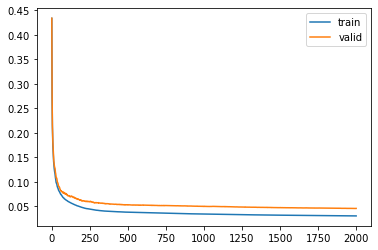

In [32]:
results = model.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='valid')
plt.legend()

### Accuracy on the testing dataset

In [47]:
y_predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, y_predictions)
print(f'\nAccuracy: {accuracy:.2f}\n')


Accuracy: 0.88



### Plotting confusion matrix

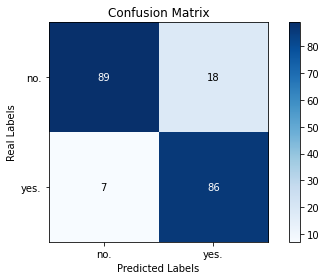

In [50]:
conf_matrix = confusion_matrix(y_test, y_predictions)

classes = ['no.', 'yes.']

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha='center', va='center',
                 color='white' if conf_matrix[i, j] > thresh else 'black')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.tight_layout()
plt.show()

# Summary

* final accuracy is equal to 88%
* disproportion in the confusion matrix errors most probably comes from unbalanced training dataset
* to increase model performance we can:
    * collect more data, especially for class "no."
    * gather domain knowledge to better understand the data and implement feature engineering